# Solve stationary Stokes problem

In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis, compile

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiga.vform import VForm, inner, grad, div, dx

def vlaplace_vf(dim):
    vf = VForm(dim, vec=dim**2)
    u, v = vf.basisfuns(components=(dim, dim))
    vf.add(inner(grad(u), grad(v)) * dx)
    return vf

def div_vf(dim):
    vf = VForm(dim, vec=dim)
    u, p = vf.basisfuns(components=(dim, 1), spaces=(0,1))
    vf.add(div(u) * p * dx)
    return vf

Asm_vlaplace, Asm_div = compile.compile_vforms(
    (vlaplace_vf(dim=2), div_vf(dim=2))
)

Compiling /home/hilbert/chofreither/.cache/pyiga/modules/mod798d43cdc4fe0b42.pyx because it changed.
[1/1] Cythonizing /home/hilbert/chofreither/.cache/pyiga/modules/mod798d43cdc4fe0b42.pyx


In [3]:
# define geometry
geo = geometry.quarter_annulus()

# define isogeometric Taylor-Hood discretization space
p = 3     # spline degree of velocity space
n_el = (50, 25)   # number of elements in y/x direction

kvs_u = tuple(bspline.make_knots(p,   0.0, 1.0, n, mult=2) for n in n_el)
kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

m_u = tuple(kv.numdofs for kv in kvs_u)
m_p = tuple(kv.numdofs for kv in kvs_p)

In [4]:
def g_lid(x, y): return (x*y*-y, x*y*x)
def g_zero(x, y):   return (0.0, 0.0)

dir_conds = [ ((0,0), g_zero), ((0,1), g_zero), ((1,0), g_lid), ((1,1), g_zero) ]

bcs = assemble.combine_bcs(
    assemble.compute_dirichlet_bc(kvs_u, geo, bcside, g)
    for (bcside, g) in dir_conds
)

In [5]:
A_grad = assemble.assemble_vector(Asm_vlaplace(kvs_u, geo))
A_div  = assemble.assemble_vector(Asm_div(kvs_u, kvs_p, geo))
M_pre  = assemble.mass(kvs_p, geo)

A_stokes = scipy.sparse.bmat(
    [[A_grad, A_div.T],
     [A_div, 1e-10*M_pre]], format='csr')

In [6]:
LS = assemble.RestrictedLinearSystem(A_stokes, 0.0, bcs)
u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u = LS.complete(u)

N = np.prod(tuple(kv.numdofs for kv in kvs_u))

In [7]:
u1 = u[:N].reshape(m_u)
u2 = u[N:2*N].reshape(m_u)
U = np.stack((u1,u2), axis=-1)
prs = u[2*N:].reshape(m_p)

velocity = geometry.BSplineFunc(kvs_u, U)
pressure = geometry.BSplineFunc(kvs_p, prs)

In [8]:
xgrid = linspace(0, 1, 30)
xygrid = (xgrid, xgrid)

G = geo.grid_eval(xygrid)
vel = velocity.grid_eval(xygrid)
pre = pressure.grid_eval(xygrid)

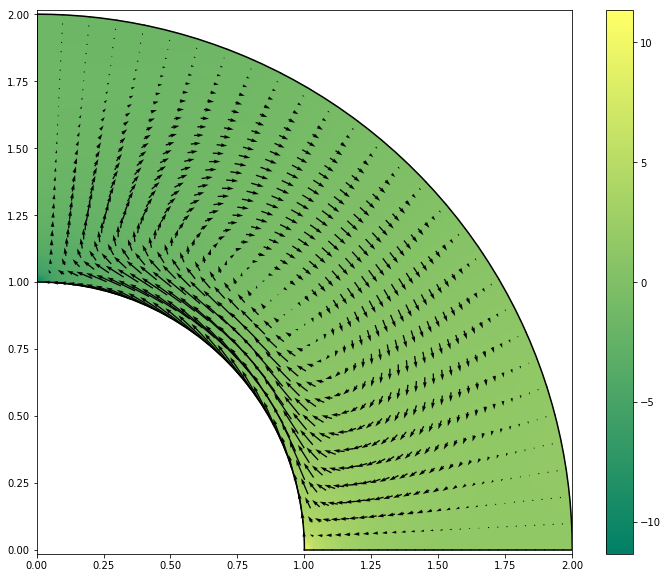

In [9]:
figsize(12,10)

vis.plot_geo(geo, grid=2)
pcolormesh(G[...,0], G[...,1], pre, cmap='summer', shading='gouraud');
colorbar();
quiver(G[...,0], G[...,1], vel[...,0], vel[...,1]);
axis('equal');